In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers # requires transformers==4.35.2
device = torch.device('cuda:0')

In [3]:
print(transformers.__version__)

4.35.2


In [4]:
model_name = "deepseek-ai/deepseek-coder-6.7b-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.float16) # , use_flash_attention=True)
model.to(device)

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaLinearScalingRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm

In [5]:
import copy
import inspect
import warnings
from dataclasses import dataclass
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.distributed as dist
from torch import nn

from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.modeling_outputs import CausalLMOutputWithPast, Seq2SeqLMOutput
from transformers.models.auto import (
    MODEL_FOR_CAUSAL_IMAGE_MODELING_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING,
    MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING,
    MODEL_FOR_VISION_2_SEQ_MAPPING,
)
from transformers.utils import ExplicitEnum, ModelOutput, is_accelerate_available, logging
from transformers.generation.beam_constraints import DisjunctiveConstraint, PhrasalConstraint
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer, ConstrainedBeamSearchScorer
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    UnbatchedClassifierFreeGuidanceLogitsProcessor,
)
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)

from transformers.generation.utils import _crop_past_key_values
import difflib

@dataclass
class GreedySearchDecoderOnlyOutput(ModelOutput):
    """
    Base class for outputs of decoder-only generation models using greedy search.


    Args:
        sequences (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
            if all batches finished early due to the `eos_token_id`.
        scores (`tuple(torch.FloatTensor)` *optional*, returned when `output_scores=True` is passed or when `config.output_scores=True`):
            Processed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
            at each generation step. Tuple of `torch.FloatTensor` with up to `max_new_tokens` elements (one element for
            each generated token), with each tensor of shape `(batch_size, config.vocab_size)`.
        attentions (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_attentions=True` is passed or `config.output_attentions=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`.
        hidden_states (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, generated_length, hidden_size)`.
    """

    sequences: torch.LongTensor = None
    scores: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None




In [6]:
@torch.no_grad()
def find_candidate_pred_tokens(input_ids, max_ngram_size=3, num_pred_tokens=10):
    input_length = input_ids.size(1)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    for ngram_size in range(max_ngram_size, 0, -1):
        # Extract the last n tokens as our search ngram
        ngram = input_ids[0, -ngram_size:].tolist()

        # Create sliding windows of size ngram_size
        windows = input_ids.unfold(dimension=1, size=ngram_size, step=1)

        # Convert ngram to a tensor for comparison
        ngram_tensor = torch.tensor(ngram, device=input_ids.device).unsqueeze(0)

        # Find where the windows match the ngram
        matches = (windows == ngram_tensor).all(dim=2)

        # Get the indices of matches
        match_indices = matches.nonzero(as_tuple=True)[1]

        # Iterate through match indices to find a valid continuation
        for idx in match_indices:
            start_idx = idx + ngram_size
            end_idx = start_idx + num_pred_tokens
            # Ensure we don't go beyond the length of input_ids and avoid self-match
            if end_idx <= input_length and start_idx < input_length - ngram_size:
                return input_ids[0, start_idx:end_idx]

    # If no match is found, return an empty tensor
    return torch.tensor([], dtype=torch.long, device=input_ids.device)

COLORS = ["\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[35m"]  # Red, Green, Blue, Magenta
UNDERLINE = "\x1b[4m"
RESET = "\x1b[0m"

@torch.no_grad()
def greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]
            
            if input_ids[0, -1] == 185 and input_ids[0, -2] == 185 and input_ids[0, -3] == 185: # hacky stopping criteria for new-line ending models
                break
            
            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [7]:
print(tokenizer.encode("..."))
print(tokenizer.encode("""
"""))
print(tokenizer.encode("##"))

[32013, 1202]
[32013, 185]
[32013, 1672]


In [23]:
code_text = """import numpy as np
import matplotlib.pyplot as plt

# Calculate the average
average_throughput = np.mean(tokens_per_sec_arr)
print(f"Average Throughput: {average_throughput} tokens/sec")

# Plotting the histogram
plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Throughput Values')
plt.xlabel('Tokens per Second')
plt.ylabel('Frequency')
plt.axvline(average_throughput, color='red', linestyle='dashed', linewidth=1)
plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
plt.show()
"""
end_text = '\nprint("END")'
code_text += end_text

question = "Can you please change x axis to start from 0"
prompt = "[INST] Code:```python\n{code_text}``` \n\n Question: {question} \n\n Modified code:[/INST]".format(code_text=code_text, question=question)

inputs = tokenizer(prompt, return_tensors="pt")
code_inputs = tokenizer(code_text, return_tensors="pt")
end_tokens = tokenizer(end_text, return_tensors="pt")

# Move all tensor values in the inputs to GPU
for key in inputs:
    inputs[key] = inputs[key].to(device)
    code_inputs[key] = code_inputs[key].to(device)
    end_tokens[key] = end_tokens[key].to(device)

In [24]:
@torch.no_grad()
def greedy_search_pld_custom(
        self,
        input_ids: torch.LongTensor,
        end_sequence: torch.LongTensor,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None
        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        original_input_length = input_ids.shape[-1]
        all_tokens = torch.Tensor([[]])
        all_tokens.to(input_ids.device)

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)

            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            first_newline = -1
            last_newline = 0
            for i in range(n_matches + 1):
                if valid_tokens[0, i] == 185:
                    if first_newline < 0:
                        first_newline = i
                    last_newline = i

            new_cache_size = -1
            all_tokens = torch.cat((input_ids, valid_tokens), dim=-1)
            if valid_tokens.shape[1] > 30: # just arbitrarily crop and use ellipses
                # print(first_newline, last_newline)
                st = valid_tokens.shape[1]
                # print(tokenizer.batch_decode(valid_tokens[:, :first_newline]))
                new_cache_size = first_newline + input_ids.shape[1]
                valid_tokens = torch.cat((valid_tokens[:, :first_newline], 
                                          torch.as_tensor([[185, 1202, 185]], dtype=torch.int32, device=input_ids.device), 
                                          valid_tokens[:, last_newline:]
                                         ), dim=-1) 
                # print("Token delta: ", st, valid_tokens.shape[1])
                
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids[0, -1] == 185 and input_ids[0, -2] == 185 and input_ids[0, -3] == 185: # hacky stopping criteria for new-line ending models
                break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1 if new_cache_size == -1 else new_cache_size
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            end_seq_len = end_sequence.shape[1]
            code_end_flag = False
            for i in range(all_tokens.shape[1] - end_seq_len + 1):
                if torch.equal(all_tokens[0, i:i+end_seq_len], end_sequence):
                    code_end_flag = True
                    break

            if code_end_flag:
                break

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [25]:
model.greedy_search_pld = greedy_search_pld.__get__(model, type(model))
# model.greedy_search_pld_diff = greedy_search_pld_diff.__get__(model, type(model))
model.greedy_search_pld_custom = greedy_search_pld_custom.__get__(model, type(model))

In [43]:
import time
from transformers import StoppingCriteriaList, MaxLengthCriteria

# Define the variable for max_new_tokens
max_new_tokens = 1000
generate_type = 'custom'

# Start timing
start_time = time.time()

# Generate the output


if generate_type == 'regular':
    out = model.generate(inputs=inputs.input_ids, max_new_tokens=max_new_tokens, use_cache=True, pad_token_id=0,
                         do_sample=False,
                         return_dict_in_generate=True)
elif generate_type == 'pld':
    out = model.greedy_search_pld(inputs.input_ids, 
                          attention_mask = inputs.attention_mask,
                          stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                          draft_matching_window_size = 3,
                          draft_num_candidate_tokens = 50,
                          use_cache=True, 
                          pad_token_id=tokenizer.pad_token_id,
                          eos_token_id=tokenizer.eos_token_id,
                          return_dict_in_generate=True)
elif generate_type == 'custom':
    out = model.greedy_search_pld_custom(inputs.input_ids, 
                                end_tokens.input_ids,
                              attention_mask = inputs.attention_mask,
                              stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                              draft_matching_window_size = 3,
                              draft_num_candidate_tokens = 100,
                              use_cache=True, 
                              pad_token_id=tokenizer.pad_token_id,
                              eos_token_id=tokenizer.eos_token_id,
                              return_dict_in_generate=True)

end_time = time.time()

out_text = tokenizer.batch_decode(out.sequences, skip_special_tokens=True)[0]


num_tokens_generated = len(out.sequences[0]) - len(inputs['input_ids'][0])

total_time = end_time - start_time
tokens_per_sec = num_tokens_generated / total_time

print(f"\n\nTotal time: {total_time} seconds")
print(f"Tokens per second: {tokens_per_sec} tokens/sec")
print(f"Total tokens generated: {num_tokens_generated}")



```python
...

plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
...

plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
...

plt.xlim(0, max(tokens_per_sec_arr))
plt.show()

print("END")
```



Total time: 0.9307379722595215 seconds
Tokens per second: 147.19502597214301 tokens/sec
Total tokens generated: 137


In [44]:
from datasets import load_dataset

ds = load_dataset("nuprl/CanItEdit", split="test")

In [45]:
print(ds)

Dataset({
    features: ['id', 'name', 'full_name', 'before', 'after', 'tests', 'instruction_descriptive', 'instruction_lazy', 'taxonomy'],
    num_rows: 105
})


In [46]:
input_token_counts = [len(tokens) for tokens in tokenizer(ds['before'])['input_ids']]

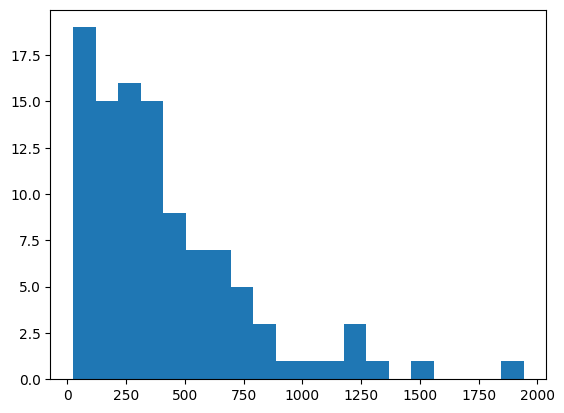

In [47]:
import matplotlib.pyplot as plt 
plt.hist(input_token_counts, bins=20)
plt.show()

In [48]:
ds = ds.add_column("token_count", input_token_counts)
ds = ds.filter(lambda example: example['token_count'] > 500)

In [53]:
max_new_tokens = 4000
total_time = 0

In [54]:
from tqdm import tqdm

for row in tqdm(ds):
    inputs = tokenizer(f"## Code Before:\n{row['before']}{end_text}\n## Instruction:\n{row['instruction_descriptive']}\n## Code After:\n", return_tensors="pt")
    code_inputs = tokenizer(row['before'], return_tensors="pt")

    # Move all tensor values in the inputs to GPU
    for key in inputs:
        inputs[key] = inputs[key].to(device)
        code_inputs[key] = code_inputs[key].to(device)

    start_time = time.perf_counter()
    out = model.greedy_search_pld_custom(inputs.input_ids, 
                            end_tokens.input_ids,
                              attention_mask = inputs.attention_mask,
                              stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                              draft_matching_window_size = 3,
                              draft_num_candidate_tokens = 70,
                              use_cache=True, 
                              pad_token_id=tokenizer.pad_token_id,
                              eos_token_id=tokenizer.eos_token_id,
                              return_dict_in_generate=True,
                                print_output=False)
    end_time = time.perf_counter()
    total_time += end_time - start_time

  0%|                                                                                      | 0/31 [00:52<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 

In [ ]:
total_time